In [1]:
# Import all packages required for this project. 
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm
import sys
import pandas
from sklearn.multiclass import OneVsRestClassifier
from pandas import DataFrame
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [2]:
# Read the files and name them accordingly
iplmatches = pd.read_csv('matches.csv')
ipldelivery = pd.read_csv('deliveries.csv')

In [3]:
#Ensure that the file is being read correctly
ipldelivery.head(5)
iplmatches.head(3)

,id,season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3
0,1,2017,Hyderabad,2017-04-05,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN
1,2,2017,Pune,2017-04-06,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN
2,3,2017,Rajkot,2017-04-07,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN


In [4]:
## BATSMEN DATA GROUPED BY MATCH
# Here the data is grouped to provide deeper depth of statistics and later for the team classificaiton

batsman_grp = ipldelivery.groupby(["match_id", "inning", "batting_team", "batsman"])
batsmen = batsman_grp["batsman_runs"].sum().reset_index()

# Ignore the wide balls.
balls_faced = ipldelivery[ipldelivery["wide_runs"] == 0]
balls_faced = balls_faced.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
balls_faced.columns = ["match_id", "inning", "batsman", "balls_faced"]
batsmen = batsmen.merge(balls_faced, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

fours = ipldelivery[ ipldelivery["batsman_runs"] == 4]
sixes = ipldelivery[ ipldelivery["batsman_runs"] == 6]

fours_per_batsman = fours.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()
sixes_per_batsman = sixes.groupby(["match_id", "inning", "batsman"])["batsman_runs"].count().reset_index()

fours_per_batsman.columns = ["match_id", "inning", "batsman", "4s"]
sixes_per_batsman.columns = ["match_id", "inning", "batsman", "6s"]

batsmen = batsmen.merge(fours_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen = batsmen.merge(sixes_per_batsman, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")
batsmen['SR'] = np.round(batsmen['batsman_runs'] / batsmen['balls_faced'] * 100, 2)

for col in ["batsman_runs", "4s", "6s", "balls_faced", "SR"]:
    batsmen[col] = batsmen[col].fillna(0)

dismissals = ipldelivery[ pd.notnull(ipldelivery["player_dismissed"])]
dismissals = dismissals[["match_id", "inning", "player_dismissed", "dismissal_kind", "fielder"]]
dismissals.rename(columns={"player_dismissed": "batsman"}, inplace=True)
batsmen = batsmen.merge(dismissals, left_on=["match_id", "inning", "batsman"], 
                        right_on=["match_id", "inning", "batsman"], how="left")

batsmen = iplmatches[['id','season']].merge(batsmen, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)
batsmen.head(10)

,season,match_id,inning,batting_team,batsman,batsman_runs,balls_faced,4s,6s,SR,dismissal_kind,fielder
0,2017,1,1,Sunrisers Hyderabad,BCJ Cutting,16,6.0,0.0,2.0,266.67,NaN,NaN
1,2017,1,1,Sunrisers Hyderabad,DA Warner,14,8.0,2.0,1.0,175.00,caught,Mandeep Singh
2,2017,1,1,Sunrisers Hyderabad,DJ Hooda,16,12.0,0.0,1.0,133.33,NaN,NaN
3,2017,1,1,Sunrisers Hyderabad,MC Henriques,52,37.0,3.0,2.0,140.54,caught,Sachin Baby
4,2017,1,1,Sunrisers Hyderabad,S Dhawan,40,31.0,5.0,0.0,129.03,caught,Sachin Baby
5,2017,1,1,Sunrisers Hyderabad,Yuvraj Singh,62,27.0,7.0,3.0,229.63,bowled,NaN
6,2017,1,2,Royal Challengers Bangalore,A Choudhary,6,2.0,0.0,1.0,300.00,NaN,NaN
7,2017,1,2,Royal Challengers Bangalore,CH Gayle,32,21.0,2.0,3.0,152.38,caught,DA Warner
8,2017,1,2,Royal Challengers Bangalore,KM Jadhav,31,16.0,4.0,1.0,193.75,run out,BCJ Cutting
9,2017,1,2,Royal Challengers Bangalore,Mandeep Singh,24,16.0,5.0,0.0,150.00,bowled,NaN


In [5]:
## Bowlers grouped by sets of data
# Data is grouped for bowlers to provide greater depth of information. Very important for the regression analysis.

bowler_grp = ipldelivery.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])
bowlers = bowler_grp["total_runs", "wide_runs", "bye_runs", "legbye_runs", "noball_runs"].sum().reset_index()

bowlers["runs"] = bowlers["total_runs"] - (bowlers["bye_runs"] + bowlers["legbye_runs"])
bowlers["extras"] = bowlers["wide_runs"] + bowlers["noball_runs"]

del( bowlers["bye_runs"])
del( bowlers["legbye_runs"])
del( bowlers["total_runs"])

dismissal_kinds_for_bowler = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
dismissals = ipldelivery[ipldelivery["dismissal_kind"].isin(dismissal_kinds_for_bowler)]
dismissals = dismissals.groupby(["match_id", "inning", "bowling_team", "bowler", "over"])["dismissal_kind"].count().reset_index()
dismissals.rename(columns={"dismissal_kind": "wickets"}, inplace=True)

bowlers = bowlers.merge(dismissals, left_on=["match_id", "inning", "bowling_team", "bowler", "over"], 
                        right_on=["match_id", "inning", "bowling_team", "bowler", "over"], how="left")
bowlers["wickets"] = bowlers["wickets"].fillna(0)

bowlers_over = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler'])['over'].count().reset_index()
bowlers = bowlers.groupby(['match_id', 'inning', 'bowling_team', 'bowler']).sum().reset_index().drop('over', 1)
bowlers = bowlers_over.merge(bowlers, on=["match_id", "inning", "bowling_team", "bowler"], how = 'left')
bowlers['Econ'] = np.round(bowlers['runs'] / bowlers['over'] , 2)
bowlers = iplmatches[['id','season']].merge(bowlers, left_on = 'id', right_on = 'match_id', how = 'left').drop('id', axis = 1)

bowlers.head(10)

C:\Users\Ammu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


,season,match_id,inning,bowling_team,bowler,over,wide_runs,noball_runs,runs,extras,wickets,Econ
0,2017,1,1,Royal Challengers Bangalore,A Choudhary,4,3,1,55,4,1.0,13.75
1,2017,1,1,Royal Challengers Bangalore,S Aravind,3,0,0,36,0,0.0,12.00
2,2017,1,1,Royal Challengers Bangalore,SR Watson,3,0,0,41,0,0.0,13.67
3,2017,1,1,Royal Challengers Bangalore,STR Binny,1,0,0,10,0,1.0,10.00
4,2017,1,1,Royal Challengers Bangalore,TM Head,1,0,0,11,0,0.0,11.00
5,2017,1,1,Royal Challengers Bangalore,TS Mills,4,2,0,31,2,1.0,7.75
6,2017,1,1,Royal Challengers Bangalore,YS Chahal,4,0,0,22,0,1.0,5.50
7,2017,1,2,Sunrisers Hyderabad,A Nehra,4,1,0,42,1,2.0,10.50
8,2017,1,2,Sunrisers Hyderabad,B Kumar,4,1,0,27,1,2.0,6.75
9,2017,1,2,Sunrisers Hyderabad,BCJ Cutting,4,2,0,35,2,0.0,8.75


In [6]:
# Ensure the data is grouped carefully. Name them accordingly as above. 
iplmatches.describe()

,id,season,dl_applied,win_by_runs,win_by_wickets,umpire3
count,636.000000,636.000000,636.000000,636.000000,636.000000,0.0
mean,318.500000,2012.490566,0.025157,13.682390,3.372642,NaN
std,183.741666,2.773026,0.156726,23.908877,3.420338,NaN
min,1.000000,2008.000000,0.000000,0.000000,0.000000,NaN
25%,159.750000,2010.000000,0.000000,0.000000,0.000000,NaN
50%,318.500000,2012.000000,0.000000,0.000000,4.000000,NaN
75%,477.250000,2015.000000,0.000000,20.000000,7.000000,NaN
max,636.000000,2017.000000,1.000000,146.000000,10.000000,NaN


Below is some Data Visualization techniques and basic Statistical Techniques

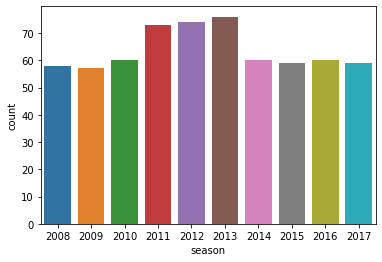

In [7]:
sns.countplot(x = 'season', data = iplmatches)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

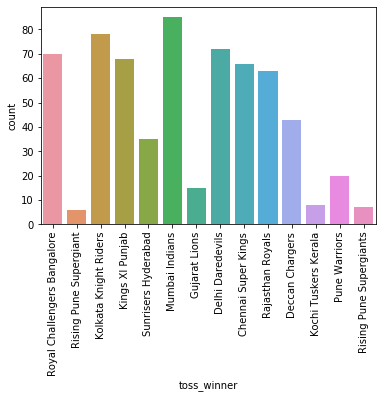

In [8]:
sns.countplot( x = 'toss_winner', data = iplmatches)
plt.xticks(rotation='vertical')

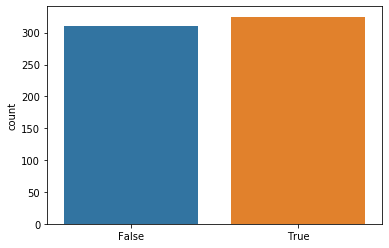

In [9]:
winneroft = iplmatches['toss_winner'] == iplmatches['winner']
winneroft.groupby(winneroft).size()
sns.countplot(winneroft)


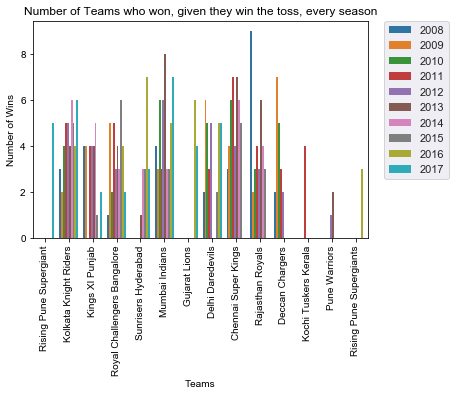

In [10]:
winneroftoss = iplmatches[(iplmatches['toss_winner']) == (iplmatches['winner'])]

wot = sns.countplot( x = 'winner', hue='season', data=winneroftoss)
sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation = 'vertical')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Teams")
plt.ylabel("Number of Wins")
plt.title("Number of Teams who won, given they win the toss, every season")
plt.show(wot)

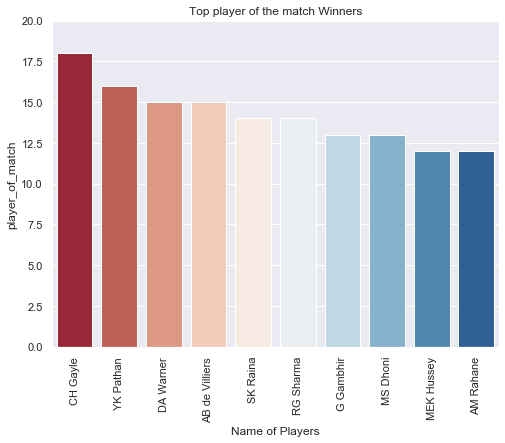

In [11]:
top_players = iplmatches.player_of_match.value_counts()[:10]
#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
ax.set_ylim([0,20])
ax.set_ylabel("Number of Awards")
ax.set_xlabel("Name of Players")
ax.set_title("Top player of the match Winners")
#top_players.plot.bar()
sns.barplot(x = top_players.index, y = top_players, orient='v', palette="RdBu");
plt.xticks(rotation = 'vertical')
plt.show()

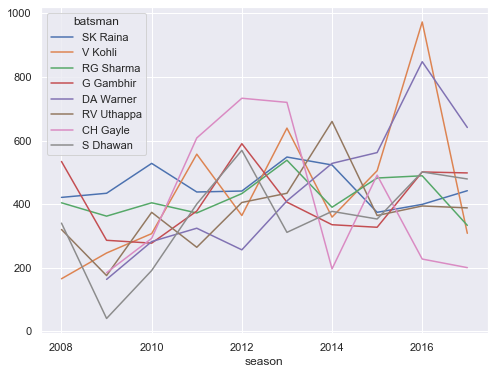

In [12]:
## Question regarding top bastsmen and top bowlers in history of IPL.

batsman_runsperseason = batsmen.groupby(['season', 'batting_team', 'batsman'])['batsman_runs'].sum().reset_index()
batsman_runsperseason = batsman_runsperseason.groupby(['season', 'batsman'])['batsman_runs'].sum().unstack().T
batsman_runsperseason['Total'] = batsman_runsperseason.sum(axis=1) #add total column to find batsman with the highest runs
batsman_runsperseason = batsman_runsperseason.sort_values(by = 'Total', ascending = False).drop('Total', 1)
ax.set_ylabel('Number of Runs')
ax = batsman_runsperseason[:8].T.plot()

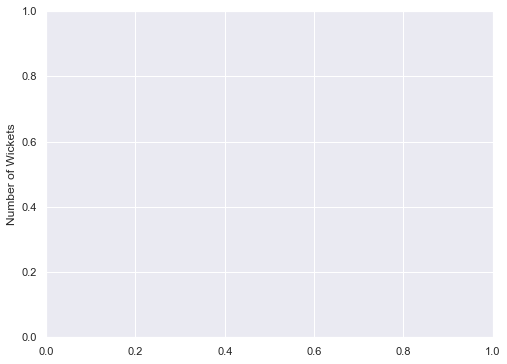

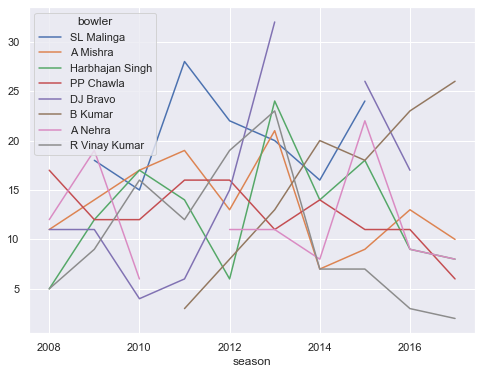

In [13]:
bowler_wicketsperseason = bowlers.groupby(['season', 'bowling_team', 'bowler'])['wickets'].sum().reset_index()
bowler_wicketsperseason = bowler_wicketsperseason.groupby(['season', 'bowler'])['wickets'].sum().unstack().T
bowler_wicketsperseason ['Total'] = bowler_wicketsperseason .sum(axis=1) #add total column to find bowler with the highest number of wickets
bowler_wicketsperseason  = bowler_wicketsperseason .sort_values(by = 'Total', ascending = False).drop('Total', 1)
plt.ylabel('Number of Wickets')
ax = bowler_wicketsperseason [:8].T.plot()

In [15]:
runs_scored=batsmen.groupby(['batsman'])['batsman_runs'].sum()
runs_scored=runs_scored.sort_values(ascending=False)
top10runs = runs_scored.head(8)
top10runs.plot('barh')

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.

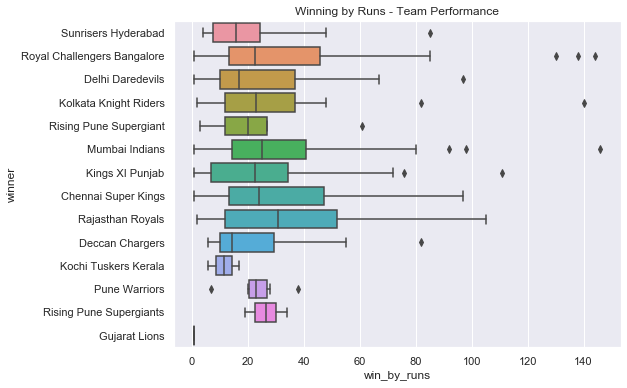

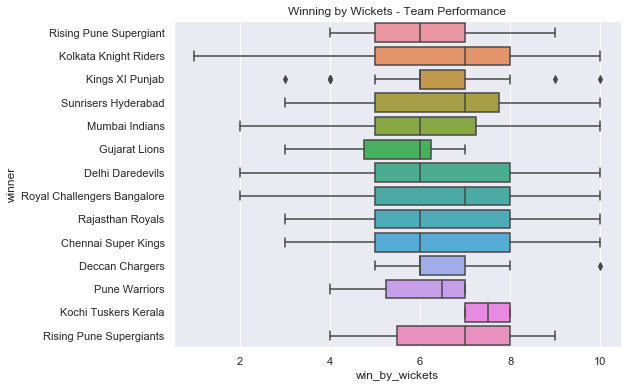

In [16]:
## Barplot of Runs

#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
#fig.figsize = [16,10]
#ax.set_ylim([0,20])
ax.set_xlabel("Runs")
ax.set_title("Winning by Runs - Team Performance")
#top_players.plot.bar()
sns.boxplot(y = 'winner', x = 'win_by_runs', data=iplmatches[iplmatches['win_by_runs']>0], orient = 'h'); #palette="Blues");
plt.show()

## Barplot of Wickets Win

#sns.barplot(x="day", y="total_bill", data=tips)
fig, ax = plt.subplots()
#fig.figsize = [16,10]
#ax.set_ylim([0,20])
ax.set_title("Winning by Wickets - Team Performance")
#top_players.plot.bar()
sns.boxplot(y = 'winner', x = 'win_by_wickets', data=iplmatches[iplmatches['win_by_wickets']>0], orient = 'h'); #palette="Blues");
plt.show()


=====================================================================================================

Now we are going to do some Classification.
Please note that I will do very little explaining and more so for the user to explore and figure out the statistical methods used under it. 


In [17]:
# Import the new Dataset.
# Now for this dataset, I removed some features that I felt were unnecessary from the original IPL
# Dataset. However, you can use that or use the one below with a screenshot of the headings.
matches = pandas.read_csv('matches1234.csv')

In [18]:
matches.head(3)

,season,city,team1,team2,toss_winner,toss_decision,winner,win_by_runs,win_by_wickets,venue,umpire1
0,2017,Hyderabad,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,Sunrisers Hyderabad,35,0,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar
1,2017,Pune,Mumbai Indians,Rising Pune Supergiants,Rising Pune Supergiants,field,Rising Pune Supergiants,0,7,Maharashtra Cricket Association Stadium,A Nand Kishore
2,2017,Rajkot,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,Kolkata Knight Riders,0,10,Saurashtra Cricket Association Stadium,Nitin Menon


In [19]:
# Make a copy of the dataset that you imported or used before
copy_data = matches.copy()


In [20]:
# As to ensure data integrity, make sure there are no missing values. In some cases you can take the mean to ensure fairness. In this case
# the values missing are types and so I filled them with these names. You could do otherwise if you wish
copy_data['city'].fillna('Dubai',inplace=True)
copy_data['umpire1'].fillna('Aleem Dar',inplace=True)

In [21]:
# Firstly, we should have a look whether the data is completed or not.
# Because the missing value will have an adverse impact on the building of regression model.

null_values_col = copy_data.isnull().sum()
null_values_col = null_values_col[null_values_col != 0].sort_values(ascending = False).reset_index()
null_values_col.columns = ["variable", "number of missing"]
null_values_col.head()

,variable,number of missing


In [22]:
print(copy_data.columns)

Index(['season', 'city', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'winner', 'win_by_runs', 'win_by_wickets', 'venue', 'umpire1'],
      dtype='object')


In [23]:
#Create now a dataframe copy of the data and all its rows and named columns.
df = DataFrame(copy_data,columns=['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1', 'winner'])

In [24]:
# Now what we have done is replace the name values with numbers. Regression can only be run with 
# numbers and not anything else. 
df['winner'].fillna('Draw', inplace=True)
df.replace(['Mumbai Indians','Kolkata Knight Riders','Royal Challengers Bangalore','Deccan Chargers','Chennai Super Kings',
                 'Rajasthan Royals','Delhi Daredevils','Gujarat Lions','Kings XI Punjab',
                 'Sunrisers Hyderabad','Rising Pune Supergiants','Kochi Tuskers Kerala','Pune Warriors']
                ,['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'],inplace=True)

encode = {'team1': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'team2': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'toss_winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13},
          'winner': {'MI':1,'KKR':2,'RCB':3,'DC':4,'CSK':5,'RR':6,'DD':7,'GL':8,'KXIP':9,'SRH':10,'RPS':11,'KTK':12,'PW':13,'Draw':14}}
df.replace(encode, inplace=True)

In [25]:
dicVal = encode['winner']
print(dicVal['MI']) #key value
print(list(dicVal.keys())[list(dicVal.values()).index(1)])

1
MI


In [26]:
# If any of the types are objects, then this needs to be changed to integers
df.dtypes

team1              int64
team2              int64
toss_decision     object
toss_winner        int64
city              object
venue             object
season             int64
win_by_runs        int64
win_by_wickets     int64
umpire1           object
winner             int64
dtype: object

In [27]:
# This allows any columns to be changed with the corresponding values.
from sklearn.preprocessing import LabelEncoder
var_mod = ['toss_decision', 'city', 'venue', 'umpire1']
le = LabelEncoder()
for i in var_mod:
    df[i] = le.fit_transform(df[i])
df.dtypes

team1             int64
team2             int64
toss_decision     int32
toss_winner       int64
city              int32
venue             int32
season            int64
win_by_runs       int64
win_by_wickets    int64
umpire1           int32
winner            int64
dtype: object

In [28]:
#Compare the data at the beginning to now, ensuring no string value remains.
df.head(150)

,team1,team2,toss_decision,toss_winner,city,venue,season,win_by_runs,win_by_wickets,umpire1,winner
0,10,3,1,3,14,23,2017,35,0,5,10
1,1,11,1,11,25,16,2017,0,7,1,11
2,8,2,1,2,27,25,2017,0,10,27,2
3,11,9,1,9,15,11,2017,0,6,2,9
4,3,7,0,3,2,14,2017,15,0,6,3
...,...,...,...,...,...,...,...,...,...,...,...
145,2,7,0,2,12,13,2009,0,9,16,7
146,4,1,0,4,5,32,2009,19,0,25,4
147,3,6,1,6,5,32,2009,0,7,21,6
148,5,9,0,5,5,32,2009,12,0,15,5


In [29]:
# Now we are going to split the training and test models in a typical 60:20:20 set.
x = df[['team1', 'team2', 'toss_decision','toss_winner','city', 'venue', 'season', 'win_by_runs', 'win_by_wickets', 'umpire1']]
y = df[['winner']]

x_model, x_test, y_model, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_model, y_model, test_size=0.2, random_state=1)

In [ ]:
##Using SVM 

In [30]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier

classifier = SVC(gamma = 'auto')
svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train, y_train)

print(svm_model.score(x_train,y_train))
print(svm_model.score(x_val,y_val))

1.0
0.14705882352941177


[0.0784313725490196, 0.18627450980392157, 0.28431372549019607, 0.2549019607843137, 0.06862745098039216, 0.049019607843137254, 0.0392156862745098, 0.029411764705882353, 0.06862745098039216]


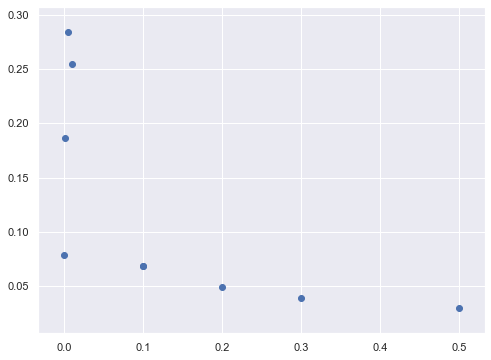

In [31]:

accuracy=[]
gamma=[0.0001, 0.001, 0.005, 0.01, 0.1, 0.2, 0.3, 0.5, 0.1]

for a in gamma:
    classifier = SVC(C=1, 
        kernel='rbf', 
        degree=2, 
        gamma=a, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(gamma, accuracy)

[0.0784313725490196, 0.16666666666666666, 0.22549019607843138, 0.18627450980392157, 0.24509803921568626, 0.2549019607843137, 0.27450980392156865, 0.24509803921568626, 0.2647058823529412, 0.27450980392156865, 0.20588235294117646, 0.2549019607843137, 0.24509803921568626, 0.2647058823529412, 0.27450980392156865, 0.28431372549019607, 0.29411764705882354]


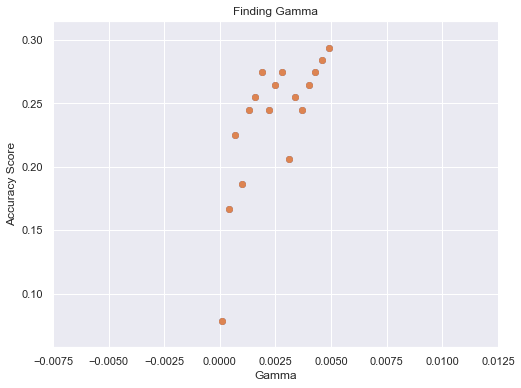

In [32]:
gamma=np.arange(0.0001, 0.005, 0.0003) 
accuracy=[]

for a in gamma:
    classifier = SVC(C=1, 
        kernel='rbf', 
        degree=2, 
        gamma=a, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(gamma, accuracy)
plt.scatter(gamma, accuracy)
plt.title("Finding Gamma")
plt.xlabel("Gamma")
plt.ylabel("Accuracy Score")
plt.show()

[0.24509803921568626, 0.27450980392156865, 0.2549019607843137, 0.24509803921568626, 0.28431372549019607, 0.23529411764705882, 0.27450980392156865, 0.2647058823529412, 0.3137254901960784]


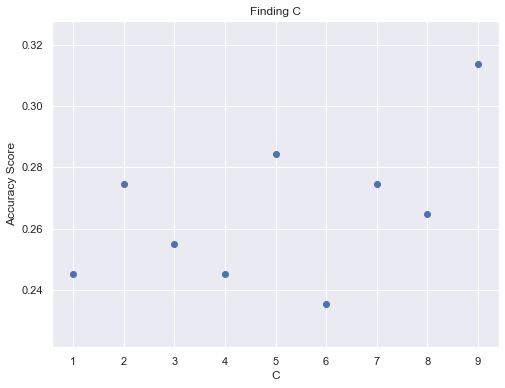

In [33]:
accuracy=[]
C=np.arange(1,10,1) 

for a in C:
    classifier = SVC(C=a, 
        kernel='rbf', 
        degree=2, 
        gamma=0.0013, 
        coef0=1,
        shrinking=True, 
        tol=0.5,
        probability=False, 
        cache_size=200, 
        class_weight=None,
        verbose=False, 
        max_iter=-1, 
        decision_function_shape=None, 
        random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1)
    svm_model.fit(x_train, y_train)
    predict=svm_model.predict(x_val)
    accuracy.append(svm_model.score(x_val,y_val))
print(accuracy)
plt.scatter(C, accuracy)
plt.title("Finding C")
plt.xlabel("C")
plt.ylabel("Accuracy Score")
plt.show()

In [34]:
classifier = SVC(C=9, # Regularization parameter
        kernel='rbf', # kernel type, rbf working fine here
        degree=2, # default value
        gamma=0.005, # kernel coefficient
        coef0=1, # change to 1 from default value of 0.0
        shrinking=True, # using shrinking heuristics
        tol=0.5, # stopping criterion tolerance 
        probability=False, # no need to enable probability estimates
        cache_size=200, # 200 MB cache size
        class_weight=None, # all classes are treated equally 
        verbose=False, # print the logs 
        max_iter=-1, # no limit, let it run
        decision_function_shape=None, # will use one vs rest explicitly 
        random_state=None)
svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train, y_train)

print(svm_model.score(x_train,y_train))
print(svm_model.score(x_val,y_val))

0.9704433497536946
0.29411764705882354


In [35]:
# Learning Curve

train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(classifier, n_jobs=1), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve \n C=1, gamma=0.0013")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

NameError: name 'learning_curve' is not defined

In [36]:
# curse of dimensionality

# one or two features are simple, but it cannot recognize and divide our categories. more features means
# more evidence in different dimensions, but it could cause overfitting.



d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = SVC(C=9, # Regularization parameter
                    kernel='rbf', # kernel type, rbf working fine here
                    degree=2, # default value
                    gamma=0.005, # kernel coefficient
                    coef0=1, # change to 1 from default value of 0.0
                    shrinking=True, # using shrinking heuristics
                    tol=0.5, # stopping criterion tolerance 
                    probability=False, # no need to enable probability estimates
                    cache_size=200, # 200 MB cache size
                    class_weight=None, # all classes are treated equally 
                    verbose=False, # print the logs 
                    max_iter=-1, # no limit, let it run
                    decision_function_shape=None, # will use one vs rest explicitly 
                    random_state=None)
    svm_model = OneVsRestClassifier(classifier, n_jobs=1).fit(x_train_index, y_train)

    d_train.append(svm_model.score(x_train_index, y_train))
    d_val.append(svm_model.score(x_val_index, y_val))

In [ ]:
plt.title('SVM Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [ ]:
## Decision Tree Classifier

In [ ]:

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(x_train, y_train)
print(decision_tree_model.score(x_train,y_train))
print(decision_tree_model.score(x_val,y_val))

In [ ]:
plt.bar(range(len(x_train.columns.values)), decision_tree_model.feature_importances_)
plt.xticks(range(len(x_train.columns.values)),x_train.columns.values, rotation= 45)
plt.title('Figure 1.7 Importance of each Feature')

In [ ]:
train_score = []
val_score = []
for depth in np.arange(1,11):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,11),train_score)
plt.plot(np.arange(1,11),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [ ]:
train_score = []
val_score = []
for depth in np.arange(1,15):
    decision_tree = tree.DecisionTreeClassifier(max_depth = depth,min_samples_leaf = 5)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,15),train_score)
plt.plot(np.arange(1,15),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Depth')
plt.ylabel('Accuracy')

In [ ]:
train_score = []
val_score = []
for leaf in np.arange(1,20):
    decision_tree = tree.DecisionTreeClassifier(max_depth = 9, min_samples_leaf = leaf)
    decision_tree.fit(x_train, y_train)
    train_score.append(decision_tree.score(x_train, y_train))
    val_score.append(decision_tree.score(x_val, y_val))

plt.plot(np.arange(1,20),train_score)
plt.plot(np.arange(1,20),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Decision Tree Tuning')
plt.xlabel('Minimum Samples Leaf')
plt.ylabel('Accuracy')

In [ ]:
my_decision_tree_model = DecisionTreeClassifier(max_depth = 9, min_samples_leaf = 3)
my_decision_tree_model.fit(x_train, y_train)
print(my_decision_tree_model.score(x_train,y_train))
print(my_decision_tree_model.score(x_val,y_val))

In [ ]:
print(my_decision_tree_model.score(x_test,y_test))

In [ ]:
y_predict_decision = my_decision_tree_model.predict(x_test)
cm = confusion_matrix(y_test, y_predict_decision) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Decision Tree \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_decision)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Learning Curve
train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6)), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Decision Tree Learning Curve \n ")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# Curse of Dimensionality

d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 6)
    dt_model = classifier.fit(x_train_index, y_train.values.ravel())

    d_train.append(dt_model.score(x_train_index, y_train))
    d_val.append(dt_model.score(x_val_index, y_val))
plt.title('Decision Tree Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [ ]:
## Using Logisitic Regression



In [ ]:
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

logistic_model = LogisticRegression()
logistic_model.fit(x_train, y_train.values.ravel())

print(logistic_model.score(x_train,y_train))
print(logistic_model.score(x_val,y_val))

In [ ]:
train_score = []
val_score=[]

for i in np.arange(1,80):
    
    logistic_model = LogisticRegression(penalty = 'l2', C = i,random_state = 0)
    
    logistic_model.fit(x_train,y_train.values.ravel()) 
    
    train_score.append(logistic_model.score(x_train, y_train))
    val_score.append(logistic_model.score(x_val,y_val))

    
plt.plot(np.arange(1,80),train_score)
plt.plot(np.arange(1,80),val_score)
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.title('Logistic Regression Tuning')
plt.xlabel('C')
plt.ylabel('Accuracy')

In [ ]:
my_logistic_regression_model = LogisticRegression(penalty = 'l2', C = 48, random_state = 0)
my_logistic_regression_model.fit(x_train, y_train)
print(my_logistic_regression_model.score(x_train,y_train))
print(my_logistic_regression_model.score(x_val,y_val))

In [ ]:
print(my_logistic_regression_model.score(x_test,y_test))

In [ ]:
y_predict_logit = my_logistic_regression_model.predict(x_test)
cm = confusion_matrix(y_test, y_predict_logit) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW'], 
                     columns = ['MI','KKR','RCB','DC','CSK','RR','DD','GL','KXIP','SRH','RPS','KTK','PW' ])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Logistic Regression \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, y_predict_logit)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
# Learning Curve

train_sizes, train_scores, val_scores = learning_curve(OneVsRestClassifier(LogisticRegression(penalty = 'l2', C = 48, random_state = 0)), 
        x_model, 
        y_model,
        # Number of folds in cross-validation
        cv=5,
        # Evaluation metric
        scoring='accuracy',
        # Use all computer cores
        # 50 different sizes of the training set
        train_sizes=np.linspace(0.1, 1.0, 5))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#ff8040",  label="Training score")
plt.plot(train_sizes, val_mean, color="#40bfff", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="#DDDDDD")

# Create plot
plt.title("Logistic Regression Learning Curve \n ")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# Curse of Dimensionality

d_train = []
d_val = []

for i in range(1,11):
    
    x_train_index = x_train.iloc[: , 0:i]
    x_val_index = x_val.iloc[: , 0:i]
    
    classifier = LogisticRegression(penalty = 'l2', C = 48, random_state = 0)
    lr_model = classifier.fit(x_train_index, y_train.values.ravel())

    d_train.append(lr_model.score(x_train_index, y_train))
    d_val.append(lr_model.score(x_val_index, y_val))

In [ ]:
plt.title('Logistic Regression Curse of Dimensionality')
plt.plot(range(1,11),d_val,label="Validation")
plt.plot(range(1,11),d_train,label="Train")
plt.xlabel('Number of Features')
plt.ylabel('Score (Accuracy)')
plt.legend()
plt.xticks(range(1,11))
plt.show()

In [ ]:
print("Logistic Regression \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_logit)))
print("Decision Tree \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_decision)))
#print("Naive Bayes \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_nb)))
#print("KNN Accuracy \nAccuracy:{0:.4f}".format(accuracy_score(y_test, y_predict_knn)))

==============================================================================================